In [ ]:
# Follows makemore implementation from karpathy, but for last names.
# https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb

In [185]:
device = torch.device("cpu")

In [186]:
names = open('compiled_names.txt', 'r').read().splitlines()
        
print(names[:5])
print(len(names))

['butterly', 'gawne', 'mouch', 'nicolaizeau', 'falson']
197029


In [187]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [188]:
## functions to convert chars to int and inverse

chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}

# . is both "before start" in X, and "im done" for Y
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}

num_char = len(stoi)
# for s, i in stoi.items():
#     print("'{}' --> {} --> '{}'".format(s, stoi[s], itos[stoi[s]]))

In [189]:
window = 3

def build_dataset(words):
    x, y = [], []

    for word in words:
        for i, c in enumerate(word + '.'):
            mini_x = []
            for w in reversed(range(1, window+1)):
                if i - w >= 0:
                    mini_x.append(stoi[word[i-w]])
                else:
                    mini_x.append(stoi['.'])

            x.append(mini_x)
            y.append(stoi[c])
            
    return torch.tensor(x, device=device), torch.tensor(y, device=device)

# for i in range(len(y)): 
#     print("{} --> {}".format([itos[c] for c in x[i]], itos[y[i]]))
        
# x = torch.tensor(x, dtype=torch.int64)
# y = torch.tensor(y, dtype=torch.int64)

In [190]:
import random
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

In [191]:
print(Xtr.shape)
print(Ytr.shape)
print(Xtr.dtype)
print(Ytr.dtype)
print(Xdev.shape)
print(Ydev.shape)
print(Xte.shape)
print(Yte.shape)

torch.Size([1275308, 3])
torch.Size([1275308])
torch.int64
torch.int64
torch.Size([159600, 3])
torch.Size([159600])
torch.Size([159219, 3])
torch.Size([159219])


In [217]:
embeddings = 10
hidden_nodes = 120

g = torch.Generator().manual_seed(2147483647)

# each char gets mapped into an embedded space
C = torch.randn((num_char, embeddings), generator=g, device=device) * 0.1
W1 = torch.randn((embeddings*window, hidden_nodes), generator=g, device=device)
b1 = torch.randn(hidden_nodes, generator=g, device=device)

W2 = torch.randn((hidden_nodes, num_char), generator=g, device=device)
b2 = torch.randn(num_char, generator=g, device=device)

# hidden = nn.Linear(6, hidden_nodes)
# final = nn.Linear(hidden_nodes, num_char)

parameters = [C, W1, b1, W2, b2]

In [218]:
sum(p.nelement() for p in parameters) # number of parameters in total

7650

In [219]:
for p in parameters:
    p.requires_grad = True

In [220]:
steps = []
losses = []
batch_size = 256
max_steps = 50000

for i in range(max_steps):
    # sample from training set
    sample_idx = torch.randint(len(Ytr), size=(batch_size,1))
    
    # forward
    emb = C[Xtr[sample_idx]]
    h = torch.tanh(emb.view(-1, window*embeddings) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, torch.squeeze(Ytr[sample_idx]))
    
    # abs
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update
    lr = 0.1 if i < 25000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    steps.append(i)
    losses.append(loss.item())
    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

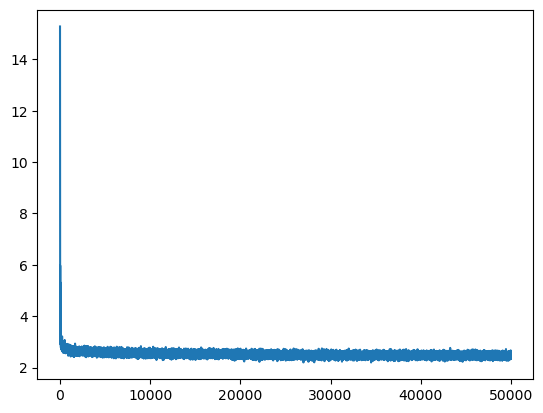

In [221]:
plt.plot(losses)

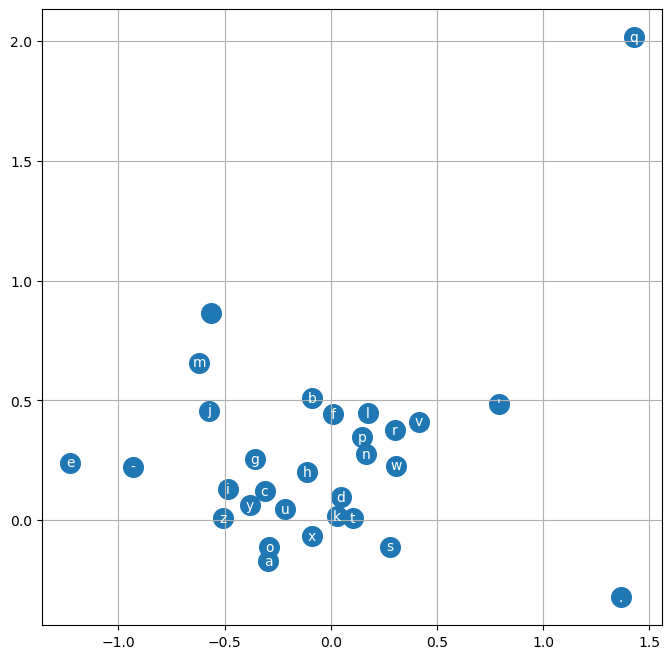

In [197]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')    

In [216]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * window # initialize with all ...
    out.append(stoi['z'])
    context = context[1:] + [stoi['z']]
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

ziixah-xiuacwdbsdsrp.
ziixiptnfxgaardhpmz-xg-aasr' rbx-nfxipnf-rdhpytvsdubdx-dcddbddnd.
ziixipthrk pbr-cgaq'bsdsbdsdbrscscdrlre-dgj  rdxdodsrd rrx  ipmz-xg-nfxgaardhpmz-xg-stsiu'bi.
ziixaasr' rpmstcrscdryk'urd rrx  ipmz-xg-aasr' rpmrkxipmz-xg-nfxgaardhpmi-xiuaasr' rpmrkxipnf-rlbsrj' rpx-xlgjvrp.
ziixa'br.
ziixipnf-rd.
ziixipnf-rlbsx-bl-sg-slsbsj-jpopzstmsgxnljokdzrqmrkxiptrsdobsrj' rpmrkxipthr.
ziixa'br.
ziixipmz-xg-aasr' rpmstgbusabsdsbdsdbrscsry  ipmi-xiuaasr' rpmrkxipnf-sdubpb-sgar''br.
ziixipnf-rlbsrj' rpx--sgjnkmsnm'br.
ziixa'br.
ziixipnf-rdhpytvsdubdx-sgubl-sgjnkyoc-cgaq'bsdssdssdsbdsdbre-dgj  ipmi-xiuatsru'br.
ziixa'br.
ziixah-xiuax.
ziixah-xiuacsdsbdhjyassdssdssdbre ozxzmzgxx'bjk'urd.
ziixipnf-rdhpytvsdubdx-dcdrykpzrtxod-sdubdx-rcury.
ziixipmi-xiuaasr' rpmrkxipnf-rlbsrj' rpmrkxipnf-rlbsrj' rpmrkxipnfziixiptrsdssdsbdsdbre-dgj  ipmz-xg-aasr' rpx-xlbsrj' rpx--sgjnkmsnlbsssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss

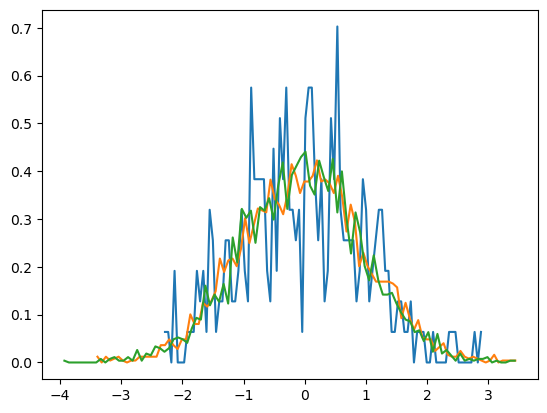

In [215]:
# for p in parameters:
#     y, x = torch.histogram(p, density=True)
#     plt.plot(x[:-1].detach(), y.detach())
cy, cx = torch.histogram(C, density=True)
plt.plot(cx[:-1].detach(), cy.detach())

w1y, w1x = torch.histogram(W1, density=True)
plt.plot(w1x[:-1].detach(), w1y.detach())
w2y, w2x = torch.histogram(W2, density=True)
plt.plot(w2x[:-1].detach(), w2y.detach())

# plt.hist(W1.detach().numpy())